In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
import re
import concurrent.futures
import tqdm
import multiprocessing
from functools import partial
import pickle

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D
from CHARMtools import spatialstat

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import pybedtools
import itertools

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False
from scipy.stats import wilcoxon

/tmp/ipykernel_540274/1907506893.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [4]:
from scipy.spatial import cKDTree

## Tune Parameters

In [5]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2]#.query('cellcycle_phase == "G1"')
acd2d_20k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/atac20kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
acd2d_20k.columns = ['chrom', 'start', 'end']
acd2d_30k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/atac30kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
acd2d_30k.columns = ['chrom', 'start', 'end']
acd2d_50k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/atac50kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
acd2d_50k.columns = ['chrom', 'start', 'end']
acd2d_100k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/atac100kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
acd2d_100k.columns = ['chrom', 'start', 'end']

me3d2d_100k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/ct100kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
me3d2d_100k.columns = ['chrom', 'start', 'end']
me3d2d_200k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/ct200kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
me3d2d_200k.columns = ['chrom', 'start', 'end']
me3d2d_300k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/ct300kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
me3d2d_300k.columns = ['chrom', 'start', 'end']
me3d2d_400k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/ct400kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
me3d2d_400k.columns = ['chrom', 'start', 'end']


In [3]:
# acd2d_30k["distance"] = acd2d_30k["end"] - acd2d_30k["start"]
# print(acd2d_30k["distance"].describe())

In [4]:
# me3d2d_300k["distance"] = me3d2d_300k["end"] - me3d2d_300k["start"]
# print(me3d2d_300k["distance"].describe())

In [5]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    # inpeak fragments
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                        column_name="atac_in2dacd20k" ,keep_3prime=True,type="allelic_resolved",peaks=acd2d_20k,flank=0)
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                        column_name="atac_in2dacd30k" ,keep_3prime=True,type="allelic_resolved",peaks=acd2d_30k,flank=0)
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                        column_name="atac_in2dacd50k" ,keep_3prime=True,type="allelic_resolved",peaks=acd2d_50k,flank=0)
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                        column_name="atac_in2dacd100k" ,keep_3prime=True,type="allelic_resolved",peaks=acd2d_100k,flank=0)
    
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz",
                     column_name="ct" ,keep_3prime=True,type="allelic_resolved")
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz",
                    column_name="ct_in2dacd100k" ,keep_3prime=True,type="allelic_resolved",peaks=me3d2d_100k,flank=0)
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz",
                    column_name="ct_in2dacd200k" ,keep_3prime=True,type="allelic_resolved",peaks=me3d2d_200k,flank=0)
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz",
                    column_name="ct_in2dacd300k" ,keep_3prime=True,type="allelic_resolved",peaks=me3d2d_300k,flank=0)
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz",
                    column_name="ct_in2dacd400k" ,keep_3prime=True,type="allelic_resolved",peaks=me3d2d_400k,flank=0)

    
    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=6,cluster_name = "atac_cluster",random_seed=42)
    cell.calc_3D_cluster(query = "ct > 0", eps = 1.7, min_samples=11,cluster_name = "ct_cluster",random_seed=42)
    
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [03:50<00:00,  3.12it/s] 


In [6]:
def _get_in_acd_ratio(cell):
    atac_bins = cell.get_data().query('atac > 0').shape[0]
    atac_bins_2d_20k = cell.get_data().query('atac_in2dacd20k > 0').shape[0]
    atac_bins_2d_30k = cell.get_data().query('atac_in2dacd30k > 0').shape[0]
    atac_bins_2d_50k = cell.get_data().query('atac_in2dacd50k > 0').shape[0]
    atac_bins_2d_100k = cell.get_data().query('atac_in2dacd100k > 0').shape[0]
    atac_bins_3d = cell.get_data().query('atac_cluster != "-1"').shape[0]

    in_2dacd_20k = atac_bins_2d_20k / atac_bins
    in_2dacd_30k = atac_bins_2d_30k / atac_bins
    in_2dacd_50k = atac_bins_2d_50k / atac_bins
    in_2dacd_100k = atac_bins_2d_100k / atac_bins
    in_3dacd = atac_bins_3d / atac_bins

    ct_bins = cell.get_data().query('ct > 0').shape[0]
    ct_bins_2d_100k = cell.get_data().query('ct_in2dacd100k > 0').shape[0]
    ct_bins_2d_200k = cell.get_data().query('ct_in2dacd200k > 0').shape[0]
    ct_bins_2d_300k = cell.get_data().query('ct_in2dacd300k > 0').shape[0]
    ct_bins_2d_400k = cell.get_data().query('ct_in2dacd400k > 0').shape[0]
    ct_bins_3d = cell.get_data().query('ct_cluster != "-1"').shape[0]
    
    in_2dme3d_100k = ct_bins_2d_100k / ct_bins
    in_2dme3d_200k = ct_bins_2d_200k / ct_bins
    in_2dme3d_300k = ct_bins_2d_300k / ct_bins
    in_2dme3d_400k = ct_bins_2d_400k / ct_bins
    in_3dme3d = ct_bins_3d / ct_bins
    
    return (in_2dacd_20k, in_2dacd_30k, in_2dacd_50k, in_2dacd_100k, in_3dacd,
            in_2dme3d_100k, in_2dme3d_200k, in_2dme3d_300k, in_2dme3d_400k,in_3dme3d)
with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    in_acd_ratios = list(tqdm.tqdm(executor.map(_get_in_acd_ratio, cells), total=len(cells)))
in_2dacd_20k = []
in_2dacd_30k = []
in_2dacd_50k = []
in_2dacd_100k = []
in_3dacd = []

in_2dme3d_100k = []
in_2dme3d_200k = []
in_2dme3d_300k = []
in_2dme3d_400k = []
in_3dme3d = []

for in_acd_ratio in in_acd_ratios:
    in_2dacd_20k.append(in_acd_ratio[0])
    in_2dacd_30k.append(in_acd_ratio[1])
    in_2dacd_50k.append(in_acd_ratio[2])
    in_2dacd_100k.append(in_acd_ratio[3])
    in_3dacd.append(in_acd_ratio[4])
    in_2dme3d_100k.append(in_acd_ratio[5])
    in_2dme3d_200k.append(in_acd_ratio[6])
    in_2dme3d_300k.append(in_acd_ratio[7])
    in_2dme3d_400k.append(in_acd_ratio[8])
    in_3dme3d.append(in_acd_ratio[9])


100%|██████████| 720/720 [07:28<00:00,  1.61it/s]


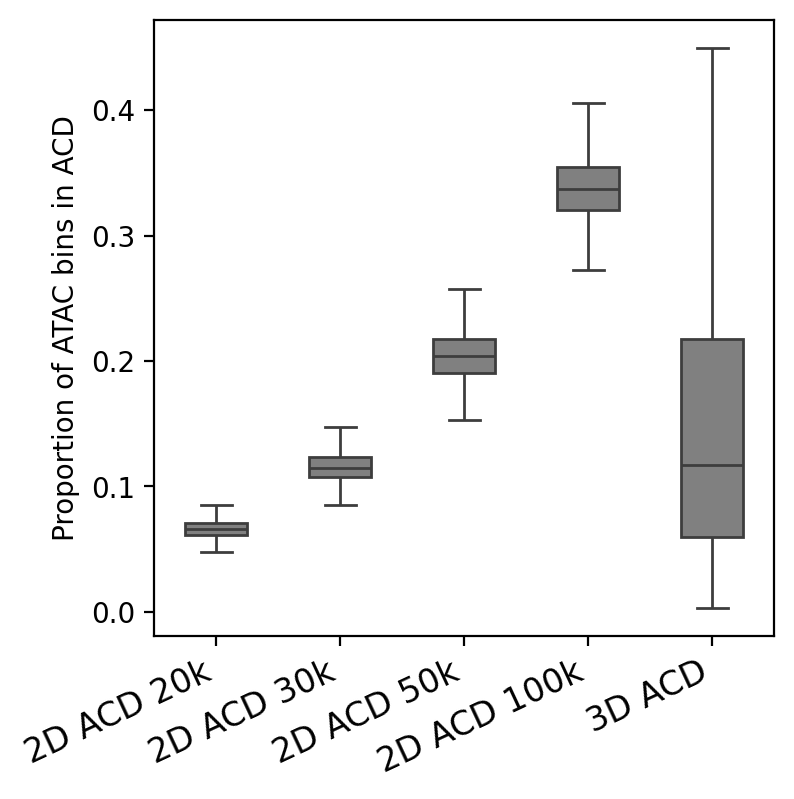

In [46]:
# boxplot 
fig = plt.figure(figsize=(4, 4))
pdata = pd.DataFrame({'in_2dacd_20k': in_2dacd_20k, 'in_2dacd_30k': in_2dacd_30k, 'in_2dacd_50k': in_2dacd_50k, 'in_2dacd_100k': in_2dacd_100k, 'in_3dacd': in_3dacd})
sns.boxplot(data=pdata, width=0.5, showfliers=False,color="grey")

plt.ylabel('Proportion of ATAC bins in ACD')
plt.xticks([0, 1, 2, 3, 4], ['2D ACD 20k','2D ACD 30k', '2D ACD 50k', '2D ACD 100k', '3D ACD'], fontsize=12)
# rotate
plt.xticks(rotation=25, ha='right')
plt.savefig("./figures/2dacd_proportion.pdf", bbox_inches='tight', dpi=300)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2D ME3D 100k'),
  Text(1, 0, '2D ME3D 200k'),
  Text(2, 0, '2D ME3D 300k'),
  Text(3, 0, '2D ME3D 400k'),
  Text(4, 0, '3D ME3D')])

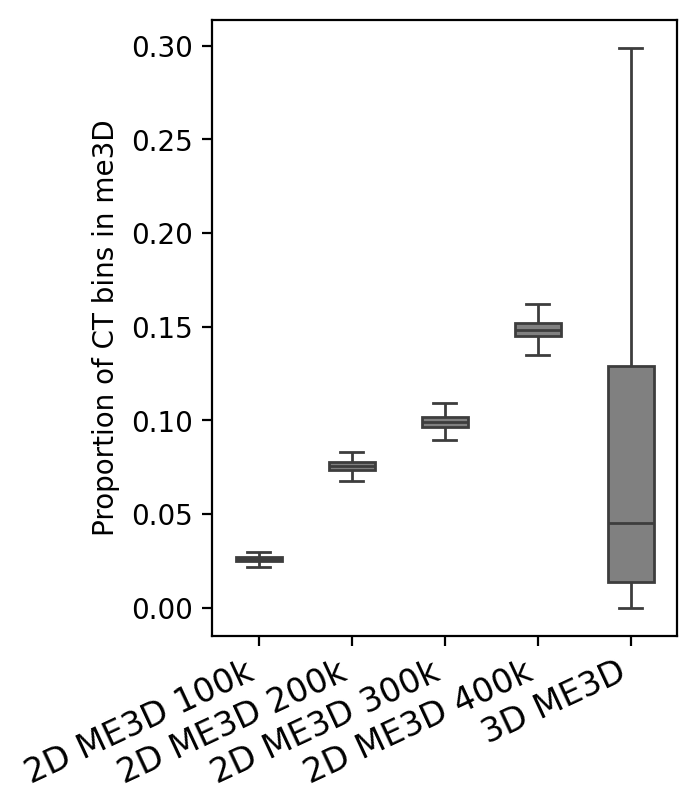

In [18]:
fig = plt.figure(figsize=(3, 4))
pdata = pd.DataFrame({'in_2dme3d_100k': in_2dme3d_100k, 'in_2dme3d_200k': in_2dme3d_200k, 'in_2dme3d_300k': in_2dme3d_300k, 'in_2dme3d_400k': in_2dme3d_400k, 'in_3dme3d': in_3dme3d})
sns.boxplot(data=pdata, width=0.5, showfliers=False,color="grey")
plt.ylabel('Proportion of CT bins in me3D')
plt.xticks([0, 1, 2, 3,4], ['2D ME3D 100k', '2D ME3D 200k', '2D ME3D 300k','2D ME3D 400k', '3D ME3D'], fontsize=12)
# rotate
plt.xticks(rotation=25, ha='right')

## Scatterplot

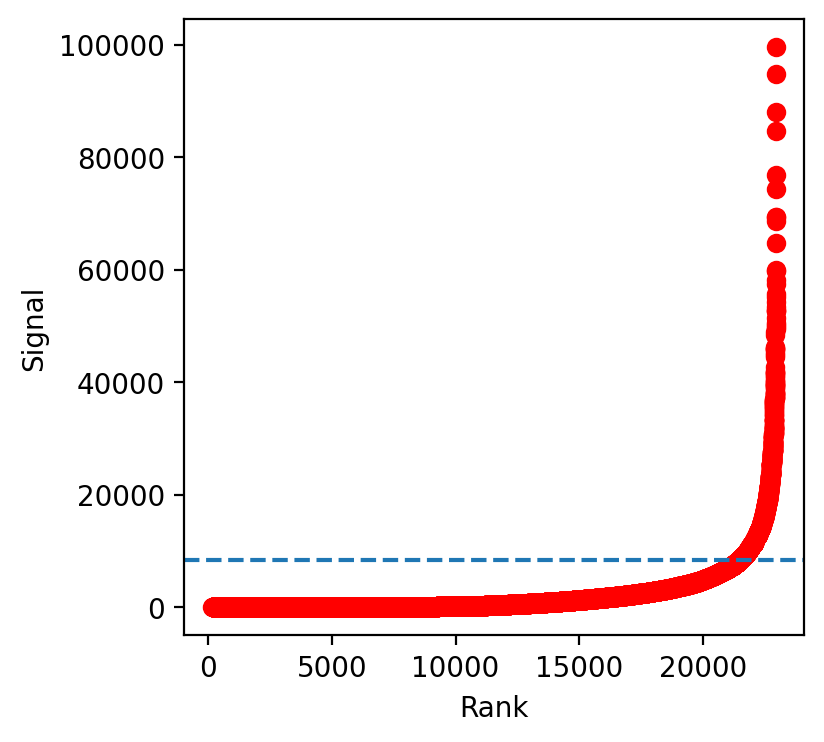

In [47]:
df = pd.read_table("./rich_regions/rose_strict_share/charm_res/atac30kwithp_AllEnhancers.table.txt",sep="\t",comment="#")
df["signal"] = df["CHARM_mesc.atac.bam"] - df["merged_100k_reads_parallel.bam"]
df['enhancerRank'] = df['enhancerRank'].rank(method='dense', ascending=False).astype(int)
plt.figure(figsize=(4,4))
plt.scatter(data = df.query('signal > 0'),x="enhancerRank",y="signal",color='red')
plt.axhline(y=8521,ls='--')
plt.ylabel("Signal")
plt.xlabel("Rank")

plt.savefig("./figures/2dacd_scatter.pdf", bbox_inches='tight', dpi=300)


## Enrichment

In [6]:
cpg = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/CpG/normal_cpg/M23.CpG.5000.txt", sep='\t', header=None)
cpg.columns = ['chrom', 'start', 'end', 'cpg']
cpg = cpg[cpg['chrom'].str.startswith('chr')]
cgp_bed = pybedtools.BedTool.from_dataframe(cpg)
acd2d_30k_bed = pybedtools.BedTool.from_dataframe(acd2d_30k)

acd_bin = cgp_bed.intersect(acd2d_30k_bed, wa = True, wb = True).to_dataframe()
acd_bin["group"] = acd_bin.groupby(['score', 'strand', 'thickStart']).ngroup()

acd_bin = acd_bin[["chrom","start","end","group"]].drop_duplicates()
acd_bin["pos"] = acd_bin["start"]
acd_bin_a = acd_bin.copy()
acd_bin_b = acd_bin.copy()
acd_bin_a["chrom"] = acd_bin_a["chrom"] + "a"
acd_bin_b["chrom"] = acd_bin_b["chrom"] + "b"
acd_bin_a["group"] = acd_bin_a["group"].astype(str) + "a"
acd_bin_b["group"] = acd_bin_b["group"].astype(str) + "b"
acd_bin = pd.concat([acd_bin_a, acd_bin_b], axis=0).reset_index(drop=True)
acd_bin = acd_bin[["chrom","pos","group"]].rename(columns={"group":"atac_cluster_2d"})

In [7]:
me3d2d_200k_bed = pybedtools.BedTool.from_dataframe(me3d2d_200k)
me3d_bin = cgp_bed.intersect(me3d2d_200k_bed, wa = True, wb = True).to_dataframe()
me3d_bin["group"] = me3d_bin.groupby(['score', 'strand', 'thickStart']).ngroup()
me3d_bin = me3d_bin[["chrom","start","end","group"]].drop_duplicates()
me3d_bin["pos"] = me3d_bin["start"]
me3d_bin_a = me3d_bin.copy()
me3d_bin_b = me3d_bin.copy()
me3d_bin_a["chrom"] = me3d_bin_a["chrom"] + "a"
me3d_bin_b["chrom"] = me3d_bin_b["chrom"] + "b"
me3d_bin_a["group"] = me3d_bin_a["group"].astype(str) + "a"
me3d_bin_b["group"] = me3d_bin_b["group"].astype(str) + "b"
me3d_bin = pd.concat([me3d_bin_a, me3d_bin_b], axis=0).reset_index(drop=True)   
me3d_bin = me3d_bin[["chrom","pos","group"]].rename(columns={"group":"ct_cluster_2d"})



In [8]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )

    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=6,cluster_name = "atac_cluster",random_seed=42)
    cell.tdg = cell.tdg.merge(acd_bin, on = ["chrom", "pos"], how = "left")
    cell.tdg["atac_cluster_2d"] = cell.tdg["atac_cluster_2d"].fillna("-1")

    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz",
                        column_name="ct" ,keep_3prime=True,type="allelic_resolved")
    cell.calc_3D_cluster(query = "ct > 0", eps = 1.7, min_samples=11,cluster_name = "ct_cluster",random_seed=42)
    cell.tdg = cell.tdg.merge(me3d_bin, on = ["chrom", "pos"], how = "left")
    cell.tdg["ct_cluster_2d"] = cell.tdg["ct_cluster_2d"].fillna("-1")

    cell.add_bed_data(
        path=f"../1_preprocess/atacpeak.bed",
        column_name="atac_peaks",keep_3prime=False,
        type="all"
    )
    cell.add_bed_data(
        path=f"../data/publicdata/ENCODE/ENCFF008XKX_encode_mESCBruce4_H3K27me3.bed.gz",
        column_name="ct_peaks",keep_3prime=False,
        type="all"
    )

    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [04:10<00:00,  2.87it/s]


In [9]:
ors_allpeaks = []
ors_2dclsuteredpeaks = []
ors_2disolatedpeaks = []

for cell in tqdm.tqdm(cells):
    temp_tdg = cell.get_data().copy()
    # all peaks 
    n_in_3d_in_peaks = temp_tdg.query('atac_peaks > 0 and atac_cluster != "-1"').shape[0]
    n_out_3d_in_peaks = temp_tdg.query('atac_peaks > 0 and atac_cluster == "-1"').shape[0]
    n_in_3d_out_peaks = temp_tdg.query('atac_peaks == 0 and atac_cluster != "-1"').shape[0]
    n_out_3d_out_peaks = temp_tdg.query('atac_peaks == 0 and atac_cluster == "-1"').shape[0]

    or_allpeak = (n_in_3d_in_peaks * n_out_3d_out_peaks) / (n_in_3d_out_peaks * n_out_3d_in_peaks)
    ors_allpeaks.append(or_allpeak)

    # 2d cluster peaks
    n_in_3d_in_peaks = temp_tdg.query('(atac_peaks > 0 and atac_cluster_2d != "-1") and atac_cluster != "-1"').shape[0]
    n_out_3d_in_peaks = temp_tdg.query('(atac_peaks > 0 and atac_cluster_2d != "-1") and atac_cluster == "-1"').shape[0]
    n_in_3d_out_peaks = temp_tdg.query('not (atac_peaks > 0 and atac_cluster_2d != "-1") and atac_cluster != "-1"').shape[0]
    n_out_3d_out_peaks = temp_tdg.query('not (atac_peaks > 0 and atac_cluster_2d != "-1") and atac_cluster == "-1"').shape[0]

    or_2dclusterpeak = (n_in_3d_in_peaks * n_out_3d_out_peaks) / (n_in_3d_out_peaks * n_out_3d_in_peaks)
    ors_2dclsuteredpeaks.append(or_2dclusterpeak)
    
    # 2d isolated peaks
    n_in_3d_in_peaks = temp_tdg.query('(atac_peaks > 0 and atac_cluster_2d == "-1") and atac_cluster != "-1"').shape[0]
    n_out_3d_in_peaks = temp_tdg.query('(atac_peaks > 0 and atac_cluster_2d == "-1") and atac_cluster == "-1"').shape[0]
    n_in_3d_out_peaks = temp_tdg.query('not (atac_peaks > 0 and atac_cluster_2d == "-1") and atac_cluster != "-1"').shape[0]
    n_out_3d_out_peaks = temp_tdg.query('not (atac_peaks > 0 and atac_cluster_2d == "-1") and atac_cluster == "-1"').shape[0]



    or_2disolatedpeak = (n_in_3d_in_peaks * n_out_3d_out_peaks) / (n_in_3d_out_peaks * n_out_3d_in_peaks)
    ors_2disolatedpeaks.append(or_2disolatedpeak)

 10%|█         | 75/720 [00:58<08:25,  1.27it/s]


KeyboardInterrupt: 

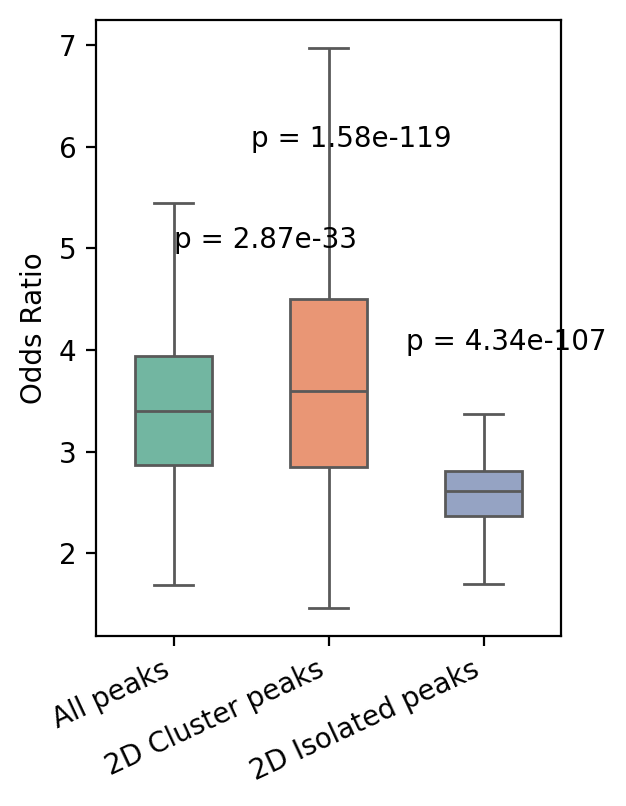

In [ ]:
# boxplot 
fig = plt.figure(figsize=(3, 4))
pdata = pd.DataFrame({'all_peaks': ors_allpeaks, '2d_cluster_peaks': ors_2dclsuteredpeaks, '2d_isolated_peaks': ors_2disolatedpeaks})
sns.boxplot(data=pdata, palette='Set2', width=0.5, showfliers=False)
plt.ylabel('Odds Ratio')
plt.xticks([0, 1, 2], ['All peaks','2D Cluster peaks', '2D Isolated peaks'])
# rotate
plt.xticks(rotation=25, ha='right')

# add wilcoxon test p value
p1 = stats.wilcoxon(ors_allpeaks, ors_2dclsuteredpeaks).pvalue
p2 = stats.wilcoxon(ors_allpeaks, ors_2disolatedpeaks).pvalue
p3 = stats.wilcoxon(ors_2dclsuteredpeaks, ors_2disolatedpeaks).pvalue

plt.text(0, 5, f'p = {p1:.2e}')
plt.text(0.5, 6, f'p = {p2:.2e}')
plt.text(1.5, 4, f'p = {p3:.2e}')

plt.savefig("./figures/2dacd_peaks_3dor_boxplot.pdf", bbox_inches='tight', dpi=300)

In [55]:
## 相比其他peak 更富集在2d acd 的peak上。
ors = []
pvs = []
for cell in tqdm.tqdm(cells):
    temp_tdg = cell.get_data().copy()
    n_in_3d_in_2d = temp_tdg.query('atac_peaks > 0 and atac_cluster != "-1" and atac_cluster_2d != "-1"').shape[0]
    n_in_3d_not_in_2d = temp_tdg.query('atac_peaks > 0 and atac_cluster != "-1" and atac_cluster_2d == "-1"').shape[0]
    n_not_in_3d_in_2d = temp_tdg.query('atac_peaks > 0 and atac_cluster == "-1" and atac_cluster_2d != "-1"').shape[0]
    n_not_in_3d_not_in_2d = temp_tdg.query('atac_peaks > 0 and atac_cluster == "-1" and atac_cluster_2d == "-1"').shape[0]

    oddsratio,pv = stats.fisher_exact([[n_in_3d_in_2d, n_in_3d_not_in_2d], [n_not_in_3d_in_2d, n_not_in_3d_not_in_2d]])
    ors.append(oddsratio)
    pvs.append(pv)


100%|██████████| 720/720 [03:52<00:00,  3.10it/s]


Median odds ratio: 1.5998632361773257


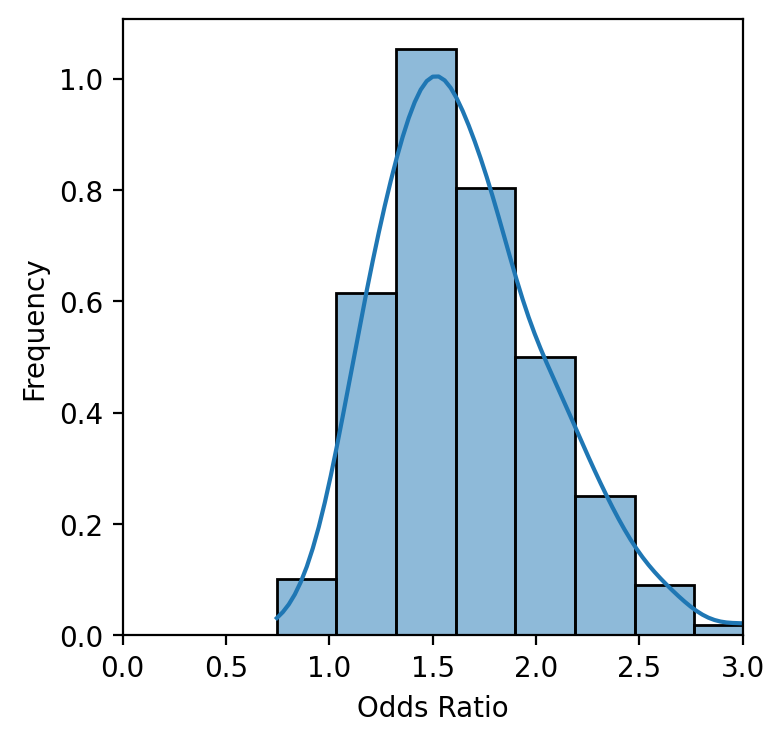

In [56]:
# histogram of odds ratio
fig = plt.figure(figsize=(4, 4))
sns.histplot(np.array(ors), bins=20, kde=True, stat='density')
plt.xlabel('Odds Ratio')
plt.ylabel('Frequency')
plt.xlim(0,3)
# print median
print("Median odds ratio:", np.median(ors))


plt.savefig("./figures/enrich_in_2dacd_peak.hist.pdf", bbox_inches='tight', dpi=300)

In [57]:
ors = []
pvs = []
for cell in tqdm.tqdm(cells):
    temp_tdg = cell.get_data().copy()
    n_in_3d_in_2d = temp_tdg.query('atac_cluster != "-1" and atac_cluster_2d != "-1"').shape[0]
    n_in_3d_not_in_2d = temp_tdg.query('atac_cluster != "-1" and atac_cluster_2d == "-1"').shape[0]
    n_not_in_3d_in_2d = temp_tdg.query('atac_cluster == "-1" and atac_cluster_2d != "-1"').shape[0]
    n_not_in_3d_not_in_2d = temp_tdg.query('atac_cluster == "-1" and atac_cluster_2d == "-1"').shape[0]

    oddsratio,pv = stats.fisher_exact([[n_in_3d_in_2d, n_in_3d_not_in_2d], [n_not_in_3d_in_2d, n_not_in_3d_not_in_2d]])
    ors.append(oddsratio)
    pvs.append(pv)


100%|██████████| 720/720 [04:05<00:00,  2.93it/s]


Median odds ratio: 2.9264731993954625


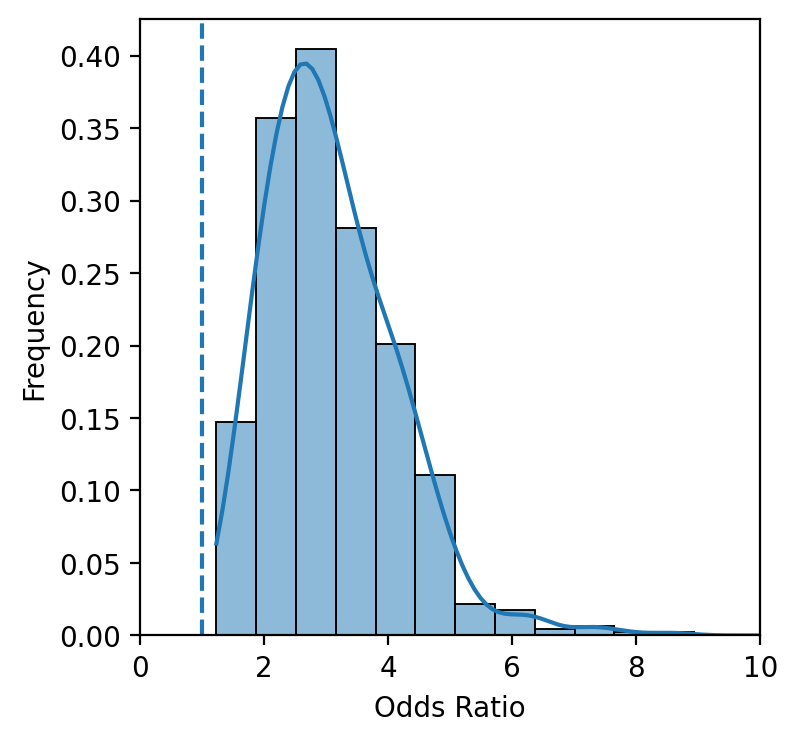

In [62]:
# histogram of odds ratio
fig = plt.figure(figsize=(4, 4))
sns.histplot(np.array(ors), bins=30)#, #kde=True, stat='density')
plt.xlabel('Odds Ratio')
plt.ylabel('Number of cells')
plt.xlim(0,10)
# print median
print("Median odds ratio:", np.median(ors))
plt.axvline(x=1,ls="dashed")
plt.savefig("./figures/enrich_in_2dacd.hist.pdf", bbox_inches='tight', dpi=300)

In [ ]:
# grouby atac_cluster, count unique types of atac_cluster_2d
dfs = []
for cell in tqdm.tqdm(cells):
    dfs.append(cell.tdg.query('atac_cluster != "-1" & atac_cluster_2d != "-1"').groupby('atac_cluster').agg({'atac_cluster_2d': lambda x: len(set(x))}).reset_index().rename(columns={"atac_cluster_2d":"atac_cluster_2d_count"}))
pdata = pd.concat(dfs, axis=0).reset_index(drop=True)

#histogram
fig = plt.figure(figsize=(4, 4))
sns.histplot(data=pdata, x="atac_cluster_2d_count", bins=np.arange(0,10,1))
plt.xlabel('Number of unique 2D ACDs in 3D ACDs')

print("Percnetage of 3D ACDs with more than 1 unique 2D ACDs: ", len(pdata.query('atac_cluster_2d_count > 1')) / len(pdata) * 100)


In [10]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )

    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=6,cluster_name = "atac_cluster",random_seed=42)

    # random 
    cell.tdg["random_atac"] = cell.tdg["atac"].sample(frac=1,random_state=42).values
    cell.calc_3D_cluster(query = "random_atac > 0", eps = 1.7, min_samples=6,cluster_name = "random_atac_cluster",random_seed=42)

    cell.tdg = cell.tdg.merge(acd_bin, on = ["chrom", "pos"], how = "left")
    cell.tdg["atac_cluster_2d"] = cell.tdg["atac_cluster_2d"].fillna("-1")

    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [02:55<00:00,  4.10it/s]


In [26]:
count_atac = []
count_random = []
for cell in tqdm.tqdm(cells):
    count_atac.append(cell.tdg.query('atac_cluster != "-1"').groupby('atac_cluster')['atac_cluster_2d'].apply(lambda x: x[x != "-1"].nunique()).values)
    count_random.append(cell.tdg.query('random_atac_cluster != "-1"').groupby('random_atac_cluster')['atac_cluster_2d'].apply(lambda x: x[x != "-1"].nunique()).values)

100%|██████████| 720/720 [03:23<00:00,  3.54it/s]  


In [55]:
(np.concatenate(count_random) > 1).mean()

0.06495832580500718

In [56]:
(np.concatenate(count_atac) > 1).mean()

0.21571822634952734

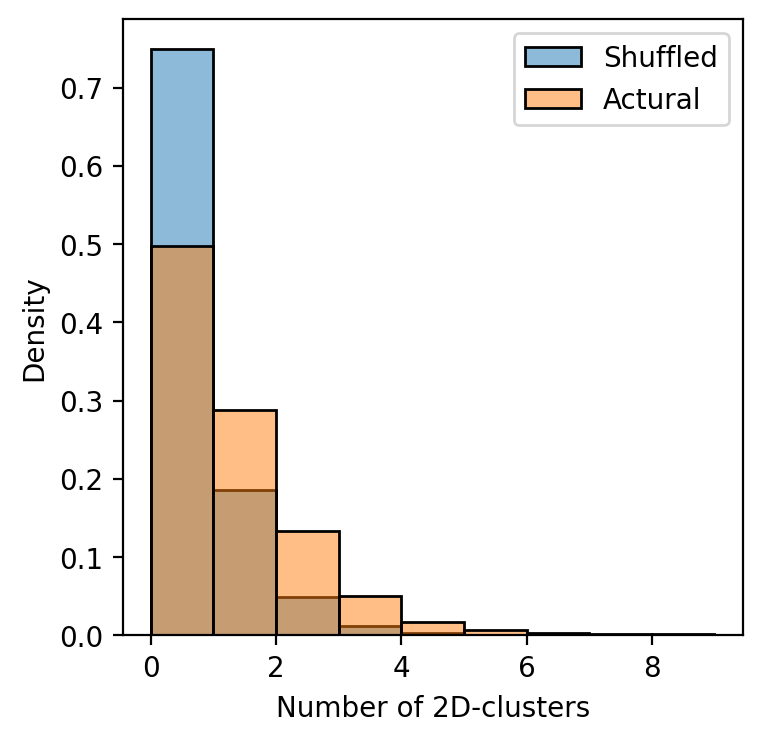

In [57]:
fig = plt.figure(figsize=(4,4))
bins = np.arange(0,10,1)
sns.histplot(
    np.concatenate(count_random),
    bins=bins,
    label = "Shuffled",
    stat="density",
    alpha=0.5
)
sns.histplot(
    np.concatenate(count_atac),
    bins=bins,
    label = "Actural",
    stat="density",
    alpha=0.5
)
plt.legend()

plt.xlabel("Number of 2D-clusters")

# save 
plt.savefig("./figures/number_of_2dcluster.hist.pdf", bbox_inches='tight', dpi=300)

100%|██████████| 720/720 [01:31<00:00,  7.91it/s]


Percnetage of 3D ACDs with more than 1 unique 2D ACDs:  42.84655830186595


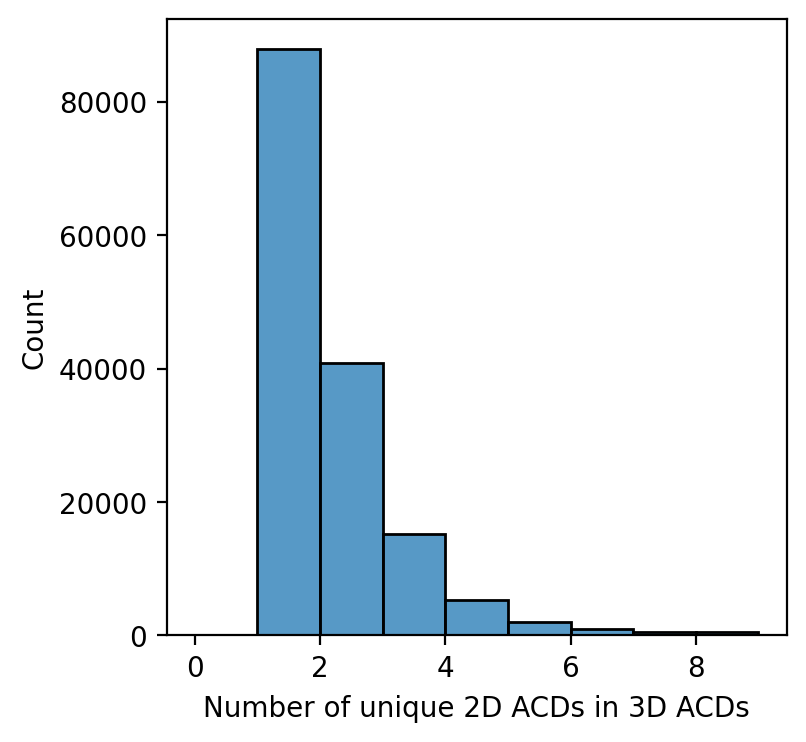

In [11]:
# grouby atac_cluster, count unique types of atac_cluster_2d
dfs = []
for cell in tqdm.tqdm(cells):
    dfs.append(cell.tdg.query('atac_cluster != "-1"').groupby('atac_cluster').agg({'atac_cluster_2d': lambda x: len(set(x))}).reset_index().rename(columns={"atac_cluster_2d":"atac_cluster_2d_count"}))
pdata = pd.concat(dfs, axis=0).reset_index(drop=True)

#histogram
fig = plt.figure(figsize=(4, 4))
sns.histplot(data=pdata, x="atac_cluster_2d_count", bins=np.arange(0,10,1))
plt.xlabel('Number of unique 2D ACDs in 3D ACDs')

print("Percnetage of 3D ACDs with more than 1 unique 2D ACDs: ", len(pdata.query('atac_cluster_2d_count > 1')) / len(pdata) * 100)


## TAD related

In [63]:
mesc_tad = pd.read_csv("./mesc_tad.bed",sep="\t",header=None)
mesc_tad.columns = ["chrom","start","end","compartment"]
mesc_tad["tad_id"] = mesc_tad.index

mesc_tad_a = mesc_tad.copy()
mesc_tad_b = mesc_tad.copy()
mesc_tad_a["chrom"] = mesc_tad_a["chrom"] + "a"
mesc_tad_b["chrom"] = mesc_tad_b["chrom"] + "b"
mesc_tad = pd.concat([mesc_tad_a, mesc_tad_b], axis=0).reset_index(drop=True)
mesc_tad["tad_id"] = mesc_tad.index

In [86]:
def get_tad_identifier(chromosome, position, tad_dataframe):
    relevant_tad_info = tad_dataframe[
        (tad_dataframe['chrom'] == chromosome) &
        (tad_dataframe['start'] <= position) &
        (tad_dataframe['end'] >= position)
    ]
    if not relevant_tad_info.empty:
        return relevant_tad_info['tad_id'].iloc[0]
    return None


def _process_cell(cell):
    try:
        temp_tdg_full = cell.tdg.copy()
        temp_tdg = temp_tdg_full.query('atac_cluster != "-1"')
        #temp_tdg = temp_tdg.groupby('atac_cluster').filter(lambda x: len(x) > 10)

        sampled_pairs_series = temp_tdg.groupby('atac_cluster').apply(lambda x: pd.Series(list(itertools.combinations(x.index, 2)))).reset_index(drop=True).sample(5000, random_state=42)
            
        count_in_same_tad = 0
        count_not_in_same_tad = 0

        for index_pair in sampled_pairs_series:
            idx_1, idx_2 = index_pair
            
            point_1_details = temp_tdg.loc[idx_1]
            point_2_details = temp_tdg.loc[idx_2]
            # only keep intra
            if point_1_details['chrom'] != point_2_details['chrom']:
                continue

            tad_id_for_point_1 = get_tad_identifier(point_1_details['chrom'], point_1_details['pos'], mesc_tad)
            tad_id_for_point_2 = get_tad_identifier(point_2_details['chrom'], point_2_details['pos'], mesc_tad)

            if tad_id_for_point_1 is not None and tad_id_for_point_2 is not None:
                if tad_id_for_point_1 == tad_id_for_point_2:
                    count_in_same_tad += 1
                else:
                    count_not_in_same_tad += 1


        random_count_in_same_tad = 0
        random_count_not_in_same_tad = 0

        # shift index  - 1e6
        for index_pair in sampled_pairs_series:
            idx_1, idx_2 = index_pair
            linear_distance = abs(idx_2 - idx_1)
            count = 0
            if_continue = False
            while True:
                count += 1
                try:
                    random_idx_1 = np.random.randint(0, len(temp_tdg_full))
                    random_idx_2 = random_idx_1 + linear_distance
                    point_1_details = temp_tdg_full.loc[random_idx_1]
                    point_2_details = temp_tdg_full.loc[random_idx_2]
                    if point_1_details['chrom'] == point_2_details['chrom']:
                        break
                except:
                    continue
                if count > 20:
                    break
            if if_continue:
                continue
            tad_id_for_point_1 = get_tad_identifier(point_1_details['chrom'], point_1_details['pos'], mesc_tad)
            tad_id_for_point_2 = get_tad_identifier(point_2_details['chrom'], point_2_details['pos'], mesc_tad)

            if tad_id_for_point_1 is not None and tad_id_for_point_2 is not None:
                if tad_id_for_point_1 == tad_id_for_point_2:
                    random_count_in_same_tad += 1
                else:
                    random_count_not_in_same_tad += 1


        return count_in_same_tad, count_not_in_same_tad, random_count_in_same_tad, random_count_not_in_same_tad

    except:
        return None, None, None, None


with concurrent.futures.ProcessPoolExecutor(max_workers=64) as executor:
   results = list(tqdm.tqdm(executor.map(_process_cell, cells), total=len(cells)))


100%|██████████| 720/720 [10:40<00:00,  1.12it/s]


In [87]:
results = [result for result in results if result[0] is not None]
ors = [stats.fisher_exact([[count_in_same_tad, count_not_in_same_tad], [random_count_in_same_tad, random_count_not_in_same_tad]])[0] for count_in_same_tad, count_not_in_same_tad, random_count_in_same_tad, random_count_not_in_same_tad in results]

count_in_same_tad = np.sum([result[0] for result in results])
count_not_in_same_tad = np.sum([result[1] for result in results])
random_count_in_same_tad = np.sum([result[2] for result in results])
random_count_not_in_same_tad = np.sum([result[3] for result in results])
# calc or
odds_ratio, p_value = stats.fisher_exact([[count_in_same_tad, count_not_in_same_tad], [random_count_in_same_tad, random_count_not_in_same_tad]])
print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 1.1439849799358344
P-value: 0.0


Median odds ratio: 1.1138761745507595


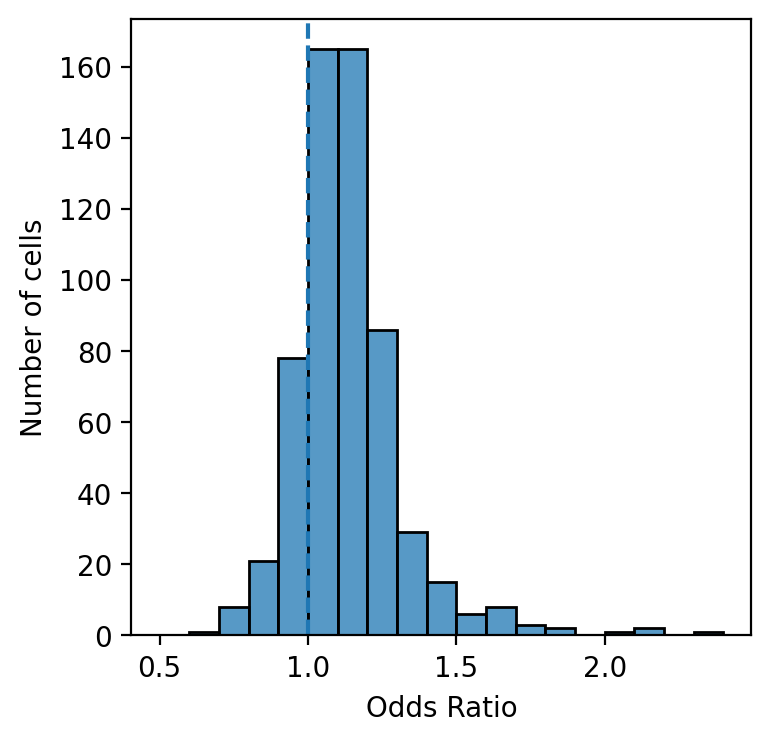

In [92]:
fig = plt.figure(figsize=(4, 4))
sns.histplot(np.array(ors), bins=np.arange(0.5,2.5,0.1))
plt.xlabel('Odds Ratio')
plt.ylabel('Number of cells')
#plt.xlim(0,10)
# print median
print("Median odds ratio:", np.median(ors))
plt.axvline(x=1,ls="dashed")
plt.savefig("./figures/enrich_in_tad.hist.pdf", bbox_inches='tight', dpi=300)

In [93]:
def _process_cell(cell):
    try:
        atac_cluster_pairs = []
        temp_tdg =cell.get_data().query('atac_cluster != "-1"')
        #temp_tdg = temp_tdg.groupby('atac_cluster').filter(lambda x: len(x) > 10)

        sampled_pairs_series = temp_tdg.groupby('atac_cluster').apply(lambda x: pd.Series(list(itertools.combinations(x.index, 2)))).reset_index(drop=True)
        # if pairs > 10000, sample 10000
        if len(sampled_pairs_series) > 10000:
            sampled_pairs_series = sampled_pairs_series.sample(10000, random_state=42)
        
        for index_pair in sampled_pairs_series:
            idx_1, idx_2 = index_pair
            
            point_1_details = temp_tdg.loc[idx_1][["chrom","pos"]]
            point_2_details = temp_tdg.loc[idx_2][["chrom","pos"]]
            
            atac_cluster_pairs.append(point_1_details.tolist() + point_2_details.tolist())

        return pd.DataFrame(atac_cluster_pairs)
    except:
        return None

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    dfs = list(tqdm.tqdm(executor.map(_process_cell, cells), total=len(cells)))

# remove None
dfs = [df for df in dfs if df is not None]

100%|██████████| 720/720 [07:53<00:00,  1.52it/s]


In [94]:
acd_pairs = pd.concat(dfs, axis=0).reset_index(drop=True)
acd_pairs.columns = ["chrom1","pos1","chrom2","pos2"]
acd_pairs["readid"] = "."
acd_pairs["chrom1"] = acd_pairs["chrom1"].str.replace("a","")
acd_pairs["chrom2"] = acd_pairs["chrom2"].str.replace("a","")
acd_pairs["chrom1"] = acd_pairs["chrom1"].str.replace("b","")
acd_pairs["chrom2"] = acd_pairs["chrom2"].str.replace("b","")
acd_pairs = acd_pairs[["readid","chrom1","pos1","chrom2","pos2"]]
acd_pairs.to_csv("./atac_cluster.pairs.gz", sep="\t", index=False, header=False)

In [85]:
mesc_tad = pd.read_csv("./mesc_tad.bed",sep="\t",header=None)
mesc_tad.columns = ["chrom","start","end","compartment"]
mesc_tad["pileup_start"] = mesc_tad["start"] - (mesc_tad["end"] - mesc_tad["start"])
mesc_tad["pileup_end"] = mesc_tad["end"] + (mesc_tad["end"] - mesc_tad["start"])
mesc_tad.query('pileup_start > 0', inplace=True)

mesc_tad["genome_coord"] = mesc_tad["chrom"] + ":" + mesc_tad["pileup_start"].astype(str) + "-" + mesc_tad["pileup_end"].astype(str)

In [83]:
import cooler
import cv2
import cooltools.lib.plotting

In [86]:
clr = cooler.Cooler("./atac_cluster.cool")
mats = []
for row in tqdm.tqdm(mesc_tad.iterrows()):
    genome_coord = row[1]["genome_coord"]
    try:
        mat = clr.matrix(balance=False).fetch(genome_coord)
        mats.append(mat)
    except:
        continue

2689it [01:10, 37.99it/s]


In [88]:
# cv2 resize to 30*30
resized_mats = []
for mat in tqdm.tqdm(mats):
    resized_mat = cv2.resize(mat, (60, 60), interpolation=cv2.INTER_NEAREST)
    resized_mats.append(resized_mat)

  0%|          | 0/2660 [00:00<?, ?it/s]

100%|██████████| 2660/2660 [00:00<00:00, 2834.08it/s]


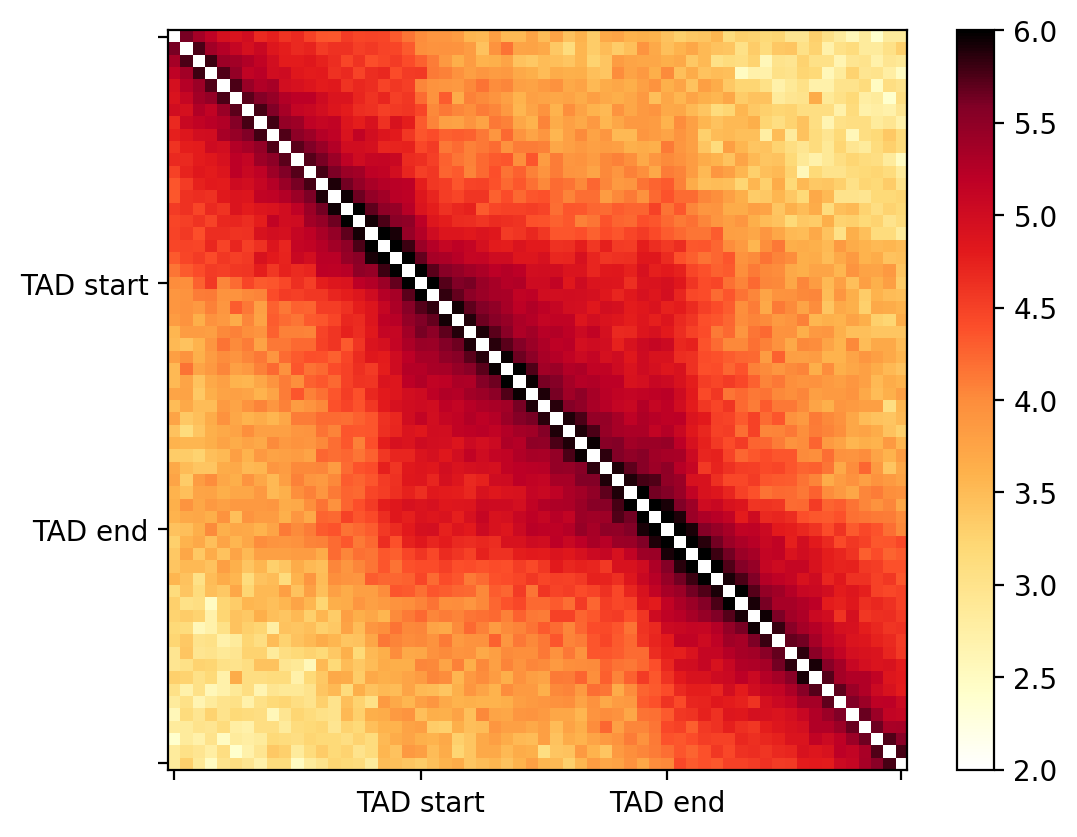

In [92]:
plt.imshow(np.log1p(np.sum(resized_mats,axis=0)),vmin=2,vmax=6, cmap="fall")

plt.xticks([0,20,40,59], ["","TAD start","TAD end",""])
plt.yticks([0,20,40,59], ["","TAD start","TAD end",""])

plt.colorbar()
plt.savefig("./figures/enrich_in_tad.heatmap.pdf", bbox_inches='tight', dpi=300)